# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../')

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
HEARTBEAT_PATH = "data/heartbeat"

# <font color=#cd0000> Análisis del Dataset HeartBeat </font>
- Fuente: http://timeseriesclassification.com/description.php?Dataset=Heartbeat

## <font color=#cd0000> Extracción de datos </font>

In [3]:
from utils.load_data import import_heartbeat_dataset

train, test = import_heartbeat_dataset(HEARTBEAT_PATH)

In [4]:
train.reset_changes()
test.reset_changes()

## <font color=#cd0000> Generación automática de reporte estadístico </font>
- No recomiendo generarla a no ser que esté llevando a cabo una replicación de mi estudio, puede llevar un tiempo generarla (aproximadamente 10 minutos).
- Puedes observar el reporte generado en el directorio raíz del proyecto con un navegador tras ejecutar esta celda.

In [42]:
# import pandas_profiling

# report = pandas_profiling.ProfileReport(train.original_data)
# report.to_file(output_file="heartbeat_report.html")

## <font color=#cd0000> Análisis a simple vista </font>
- Analizaremos los datos generados por el reporte automático de estadísticas brindado por Pandas-Profiling.

### <font color=#cd0000> Concentración de los datos </font>
- **Todos** los valores de **todos** los atributos se encuentran concentrados alrededor del 0 (todos con valores positivos).
- Los datos no se encuentran normalizados y podemos observar atributos con valores del orden de $10^{-8}$ y valores reales entre 1 y 50.
  - Convendría llevar a cabo una normalización si nos enfrentásemos a un modelo que la necesite como es el caso de LSTM.

### <font color=#cd0000> Missing Values </font>
  - Observamos que carece de missing values.

### <font color=#cd0000> Matriz de correlación </font>
- Estudiando la matriz de correlación generada a partir del coeficiente de correlación de Pearson observamos que:
  - Todos los atributos se encuentran altamente correlacionados, en especial, aquellos que son vecinos en número de señal (el atributo `signal_1` se encuentra más correlacionado con `signal_2` que con `signal_60`).
  - La correlación es muy positiva para las dimensiones vecinas y nula para aquellas muy lejanas entre sí en vecindad.
    - Lo anterior sugiere que podríamos eliminar aquellas dimensiones vecinas para agilizar el tratamiento de datos.

### <font color=#cd0000> Balanceo de las clases </font>
- Nos enfrentamos a un problema de clases desbalanceadas:
  - Tenemos 59535 clases del tipo `abnormal` y 23085 del tipo `normal`

## <font color=#cd0000> Análisis en profundidad </font>
- Analizaremos las series de cada atributo en mayor profundidad.

### <font color=#cd0000> Disminución de la dimensionalidad </font>
- Dado que las dimensiones tienen una alta correlación entre dimensiones cercanas entre sí vamos a coger únicamente una de cada diez dimensiones dando lugar al estudio de, únicamente 6 señales.

In [43]:
columns_to_remove = train.get_derived_data_columns()['attrs']
column_to_study = ['signal_1', 'signal_10', 'signal_20',
                   'signal_30', 'signal_40', 'signal_50', 'signal_60']

for col in columns_to_remove:
    if col in column_to_study:
        columns_to_remove.remove(col)

train.drop_derived_data_columns(columns_to_remove)
test.drop_derived_data_columns(columns_to_remove)

,id,TimeStamp,signal_1,signal_10,signal_20,signal_30,signal_40,signal_50,signal_60,class
0,0,0,0.004578,0.009483,0.003414,0.009437,0.008221,0.030211,1.000400,normal
1,0,1,0.011682,0.013566,0.004089,0.012686,0.012927,0.070100,0.673670,normal
2,0,2,0.017709,0.019086,0.011413,0.030151,0.039722,0.100600,0.904520,normal
3,0,3,0.016318,0.017490,0.016408,0.044615,0.059496,0.091279,1.322500,normal
4,0,4,0.011723,0.008481,0.008594,0.025718,0.030744,0.024211,1.622600,normal
...,...,...,...,...,...,...,...,...,...,...
83020,204,400,0.007057,0.001993,0.005595,0.003932,0.002723,0.002055,0.353420,abnormal
83021,204,401,0.012607,0.002142,0.004760,0.000763,0.002429,0.001636,0.349890,abnormal
83022,204,402,0.011410,0.004370,0.000505,0.000902,0.002300,0.001022,0.264820,abnormal
83023,204,403,0.008735,0.003033,0.001830,0.001835,0.004181,0.002472,0.130270,abnormal


### <font color=#cd0000> Generación automática de reporte estadístico con reducción de la dimensionalidad </font>
- Puedes observar el reporte generado en el fichero `./Pruebas/HeartBeat/report/heartbeat_report.html` con un navegador

In [44]:
# import pandas_profiling

# report = pandas_profiling.ProfileReport(train.derived_data)
# report.to_file(output_file="heartbeat_report.html")

### <font color=#cd0000> Desplazamiento entre los atributos </font>
- No observamos que las series se encuentren desplazadas entre sí aunque sí observamos que existen series de mayor amplitud que otras por lo que estandarizar los datos es algo más que necesario si no queremos que una señal destaque sobre las demás.

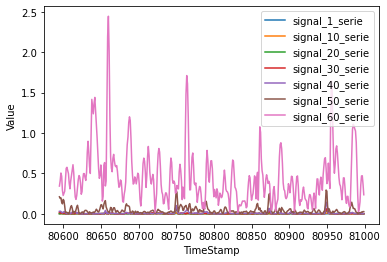

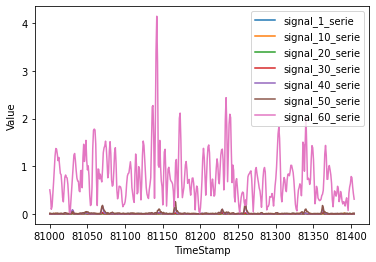

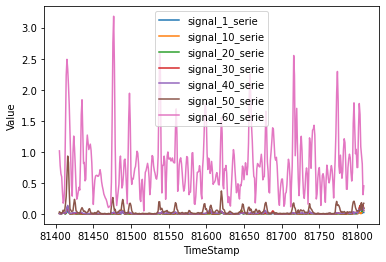

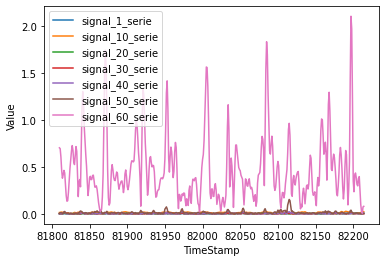

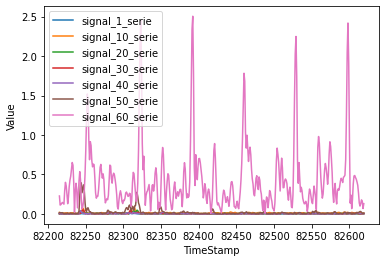

In [45]:
from utils.plot_utils import plot_series
import pandas as pd

def plot_all_signals_from_serie_id(df, id):
    serie_id = id

    signal_1_serie = df[df['id'] == serie_id]['signal_1']
    signal_10_serie = df[df['id'] == serie_id]['signal_10']
    signal_20_serie = df[df['id'] == serie_id]['signal_20']
    signal_30_serie = df[df['id'] == serie_id]['signal_30']
    signal_40_serie = df[df['id'] == serie_id]['signal_40']
    signal_50_serie = df[df['id'] == serie_id]['signal_50']
    signal_60_serie = df[df['id'] == serie_id]['signal_60']

    series_to_plot = [signal_1_serie, signal_10_serie, signal_20_serie,
                    signal_30_serie, signal_40_serie, signal_50_serie,
                    signal_60_serie]

    labels = ["signal_1_serie",
            "signal_10_serie",
            "signal_20_serie",
            "signal_30_serie",
            "signal_40_serie",
            "signal_50_serie",
            "signal_60_serie"]

    plot_series(series_to_plot, labels)

identificators = pd.unique(train.derived_data['id'])

for identificator in identificators[-5:]:
        plot_all_signals_from_serie_id(train.derived_data, identificator)

### <font color=#cd0000> Variabilidad y velocidad de cambios </font>
- Observamos que los cambios significativos se dan en diferentes frecuencias como era de esperar en un dataset con tantas dimensiones.

#### <font color=#2451ff> Clase normal </font>
- Observamos que la velocidad de los cambios es algo baja por lo que podría ser interesante reducir la frecuencia de medida para observar cambios a más largo plazo.

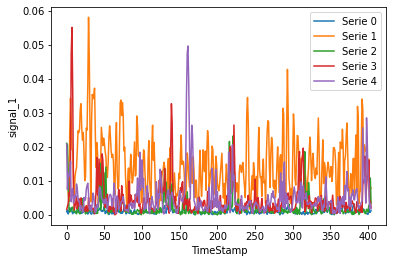

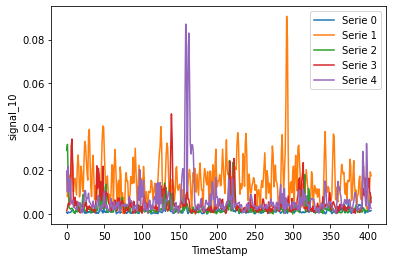

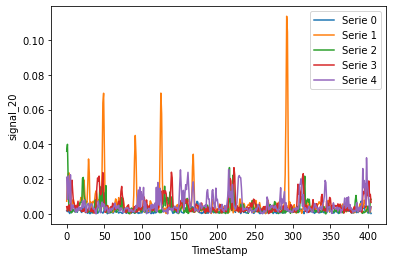

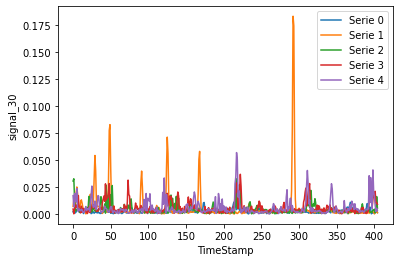

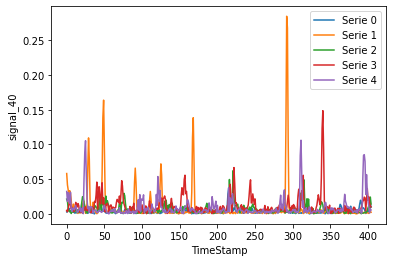

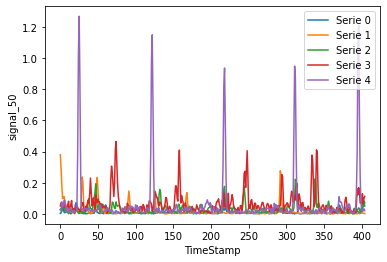

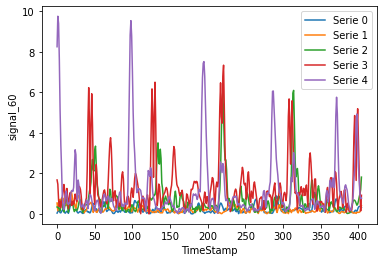

In [46]:
import pandas as pd

normal_identificators = pd.unique(
    train.original_data[train.original_data['class'] == 'normal']['id'])

train.plot_series_by_id(normal_identificators[0:5], "signal_1")
train.plot_series_by_id(normal_identificators[0:5], "signal_10")
train.plot_series_by_id(normal_identificators[0:5], "signal_20")
train.plot_series_by_id(normal_identificators[0:5], "signal_30")
train.plot_series_by_id(normal_identificators[0:5], "signal_40")
train.plot_series_by_id(normal_identificators[0:5], "signal_50")
train.plot_series_by_id(normal_identificators[0:5], "signal_60")


#### <font color=#2451ff> Clase abnormal </font>
- Observamos que la velocidad de los cambios es bastante alta por lo que, reducir la frecuencia de las series de esta clase, será perjudicial para nuestro clasificador.

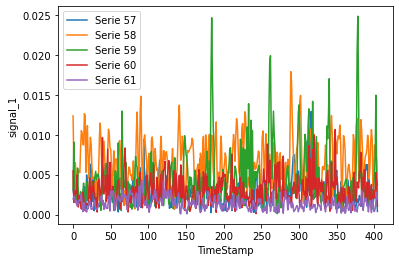

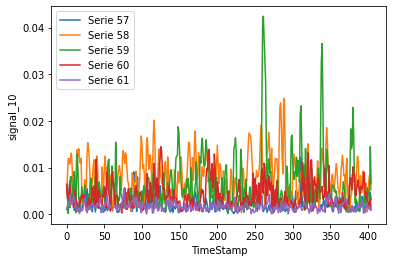

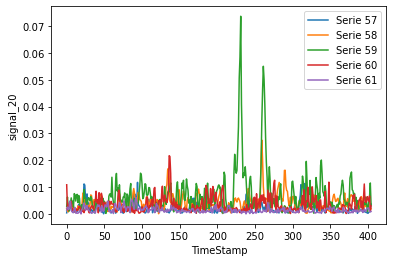

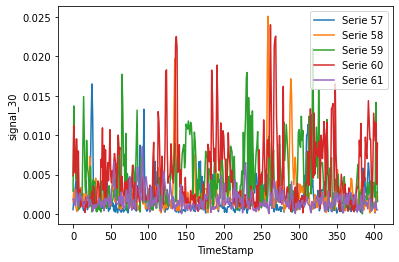

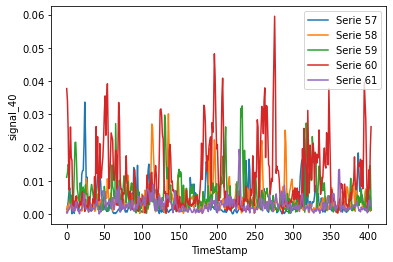

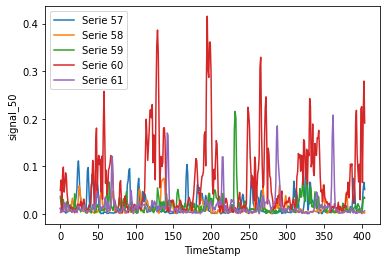

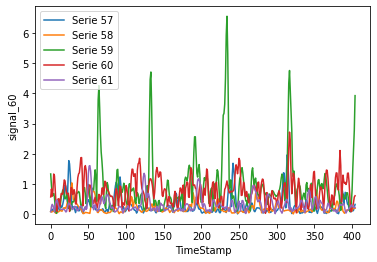

In [47]:
import pandas as pd

abnormal_identificators = pd.unique(
    train.original_data[train.original_data['class'] == 'abnormal']['id'])

train.plot_series_by_id(abnormal_identificators[0:5], "signal_1")
train.plot_series_by_id(abnormal_identificators[0:5], "signal_10")
train.plot_series_by_id(abnormal_identificators[0:5], "signal_20")
train.plot_series_by_id(abnormal_identificators[0:5], "signal_30")
train.plot_series_by_id(abnormal_identificators[0:5], "signal_40")
train.plot_series_by_id(abnormal_identificators[0:5], "signal_50")
train.plot_series_by_id(abnormal_identificators[0:5], "signal_60")


### <font color=#cd0000> Estacionariedad de las series </font>
- Podemos observar que las series no son periódicas por lo que no podemos tratarlas con un Análisis de Fourier.

### <font color=#cd0000> Tendencia de las series </font>
- No observamos ningún tipo de tendencia en las series desde un punto de vista global por lo que, estandarizar los datos, no afectará negativamente en la extracción característica de ninguna tendencia que pudieran tener.

#### <font color=#cd0000> Normalización de los datos </font>
- No observamos ninguna pérdida significativa de la información que contiene la serie al normalizarla (no perdemos tendencia porque tampoco tenemos).

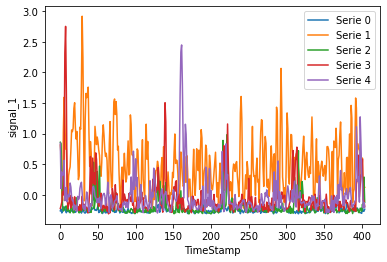

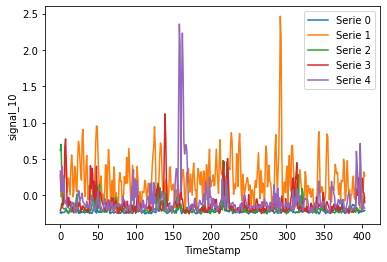

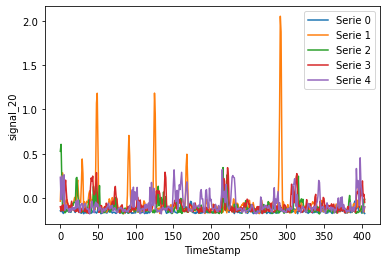

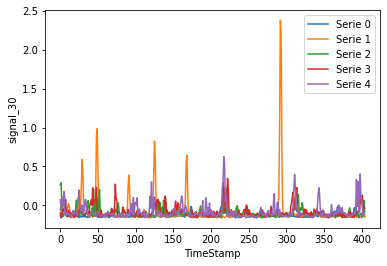

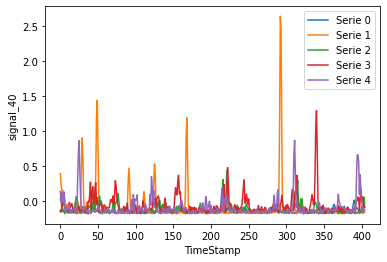

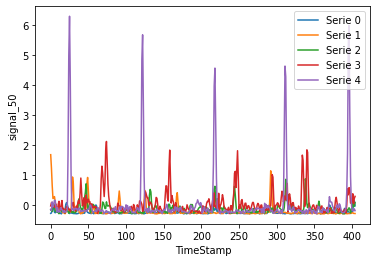

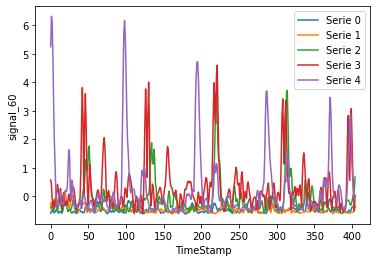

In [48]:
from utils.codifications import standardize_data
from utils.plot_utils import plot_series_from_df_by_id

columns = train.get_derived_data_columns()['attrs']
standardized_data = standardize_data(train.original_data, headers=columns)

identificators = pd.unique(standardized_data['id'])

plot_series_from_df_by_id(standardized_data, identificators[0:5], "signal_1")
plot_series_from_df_by_id(standardized_data, identificators[0:5], "signal_10")
plot_series_from_df_by_id(standardized_data, identificators[0:5], "signal_20")
plot_series_from_df_by_id(standardized_data, identificators[0:5], "signal_30")
plot_series_from_df_by_id(standardized_data, identificators[0:5], "signal_40")
plot_series_from_df_by_id(standardized_data, identificators[0:5], "signal_50")
plot_series_from_df_by_id(standardized_data, identificators[0:5], "signal_60")

# <font color=#cd0000> Aplicación preliminar de las nociones anteriores </font>

In [49]:
from utils.codifications import temporal_trend_fn

train.apply_codifications([temporal_trend_fn])
test.apply_codifications([temporal_trend_fn])

## <font color=#cd0000> Sobre SMTS </font>

In [50]:
from smts_implementation.smts import SMTS

clf = SMTS(j_ins=100, n_symbols=150, random_state=2)
clf.fit(train.derived_data.drop(['TimeStamp', 'class'], axis=1),
        train.derived_data['class'])
clf.score(test.derived_data.drop(['TimeStamp', 'class'], axis=1),
          test.derived_data['class'])


0.7365853658536585

In [51]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(test.derived_data.drop(['TimeStamp', 'class'], axis=1))
y_real = test.derived_data.groupby('id').first()['class'].to_numpy()

print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred))

[[127  21]
 [ 33  24]]
              precision    recall  f1-score   support

    abnormal       0.79      0.86      0.82       148
      normal       0.53      0.42      0.47        57

    accuracy                           0.74       205
   macro avg       0.66      0.64      0.65       205
weighted avg       0.72      0.74      0.73       205



## <font color=#cd0000> Sobre RF </font>

In [52]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=100, n_estimators=150)
clf.fit(train.derived_data.drop(['id', 'class'], axis=1),
        train.derived_data['class'])
clf.score(test.derived_data.drop(['id', 'class'], axis=1),
          test.derived_data['class'])


0.7152137164936005

In [53]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(test.derived_data.drop(['id', 'class'], axis=1))
y_real = test.derived_data['class'].to_numpy()

print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred))

[[55611  4181]
 [19405  3623]]
              precision    recall  f1-score   support

    abnormal       0.74      0.93      0.83     59792
      normal       0.46      0.16      0.24     23028

    accuracy                           0.72     82820
   macro avg       0.60      0.54      0.53     82820
weighted avg       0.66      0.72      0.66     82820



## <font color=#cd0000> Sobre LSTM </font>

### <font color=#cd0000> Preparación de los datos </font>

In [54]:
from utils.codifications import standardize_data

train.derived_data, test.derived_data = standardize_data(
    train.derived_data,
    test.derived_data,
    headers=train.get_derived_data_columns()['attrs']
)

In [63]:
# All lengths must be equal
series_length = train.get_shortest_serie().shape[0]
n_dims = len(train.get_derived_data_columns()['attrs'])

(
    train.get_shortest_serie().shape[0],
    train.get_largest_serie().shape[0],
    test.get_shortest_serie().shape[0],
    test.get_largest_serie().shape[0]
)


(404, 404, 404, 404)

In [64]:
import pandas as pd

# This will determine the number of series of each split
train_n_series = pd.unique(train.derived_data['id']).shape[0]
test_n_series = pd.unique(test.derived_data['id']).shape[0]

(train_n_series, test_n_series)


(204, 205)

In [65]:
X_train, _ = train.transform_derived_data_into_X_y()
X_test, _ = test.transform_derived_data_into_X_y()

y_train = train.derived_data.groupby('id').first()['class'].to_numpy()
y_test = test.derived_data.groupby('id').first()['class'].to_numpy()


In [66]:
from utils.classifier_utils import apply_lstm_format
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(y_train)

X_train, y_train = apply_lstm_format(
    X_train, y_train, train_n_series, series_length, 2, enc)
X_test, y_test = apply_lstm_format(
    X_test, y_test, test_n_series, series_length, 2, enc)


### <font color=#cd0000> Diseño del modelo </font>

In [67]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense

nn = Sequential()

# Number of initial dimensions
nn.add(LSTM(units=24, dropout=.2, recurrent_dropout=.2))
# Number of Epilepsy's classes
nn.add(Dense(1, activation='sigmoid'))

### <font color=#cd0000> Compilación del modelo </font>

In [74]:
from keras.optimizers import RMSprop

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]
nn.compile(optimizer=RMSprop(learning_rate=1e-5), 
           loss='binary_crossentropy', metrics=metrics)
nn.build(input_shape=X_train.shape)

### <font color=#cd0000> Visualización de métricas </font>

In [75]:
import matplotlib.pyplot as plt


def show_metrics(history):
    for metric in history.history.keys():
        if not metric.startswith('val_'):
            plt.plot(history.history[metric], label=metric)
            plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
            plt.title(metric)
            plt.ylabel('')
            plt.xlabel('Epoch')
            plt.legend(loc="upper left")
            plt.show()


### <font color=#cd0000> Entrenamiento </font>

Epoch 1/100
13/13 [==============================] - 1s 99ms/step - loss: 0.4838 - ACC: 1.0000 - Prec: 0.6081 - Rec: 0.3947 - AUC: 0.7849 - val_loss: 0.5418 - val_ACC: 1.0000 - val_Prec: 0.5167 - val_Rec: 0.2719 - val_AUC: 0.7247
Epoch 2/100
13/13 [==============================] - 1s 65ms/step - loss: 0.4871 - ACC: 1.0000 - Prec: 0.6418 - Rec: 0.3772 - AUC: 0.7896 - val_loss: 0.5413 - val_ACC: 1.0000 - val_Prec: 0.5167 - val_Rec: 0.2719 - val_AUC: 0.7249
Epoch 3/100
13/13 [==============================] - 1s 67ms/step - loss: 0.4855 - ACC: 1.0000 - Prec: 0.6571 - Rec: 0.4035 - AUC: 0.7902 - val_loss: 0.5404 - val_ACC: 1.0000 - val_Prec: 0.5167 - val_Rec: 0.2719 - val_AUC: 0.7257
Epoch 4/100
13/13 [==============================] - 1s 66ms/step - loss: 0.4797 - ACC: 1.0000 - Prec: 0.6081 - Rec: 0.3947 - AUC: 0.7932 - val_loss: 0.5404 - val_ACC: 1.0000 - val_Prec: 0.5167 - val_Rec: 0.2719 - val_AUC: 0.7259
Epoch 5/100
13/13 [==============================] - 1s 67ms/step - loss: 0.4770

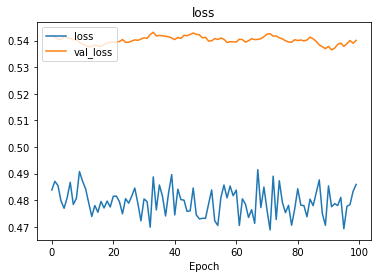

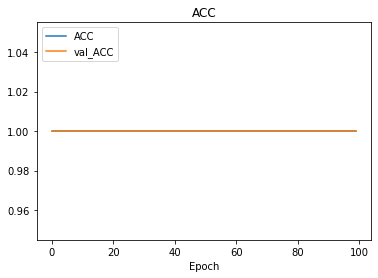

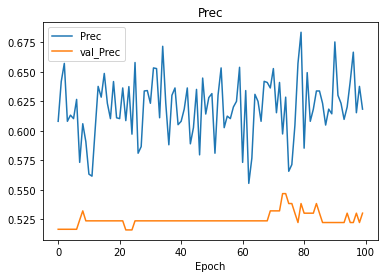

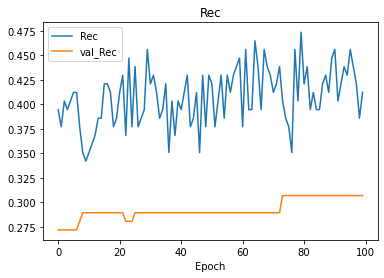

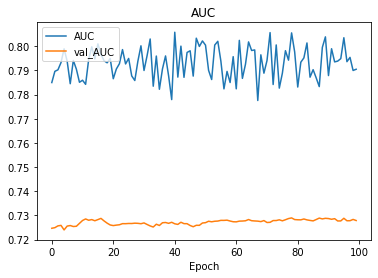

In [76]:
from sklearn.metrics import confusion_matrix, classification_report

epochs = 100

history = nn.fit(X_train, y_train, epochs=epochs,
                 validation_data=(X_test, y_test))
nn.summary()
print('\n\n')

y_pred = nn.predict(X_test)
y_pred = y_pred > 0.5

show_metrics(history)

In [77]:
y_real = y_test
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

[[265  31]
 [ 79  35]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       296
           1       0.53      0.31      0.39       114

    accuracy                           0.73       410
   macro avg       0.65      0.60      0.61       410
weighted avg       0.70      0.73      0.71       410

